<a href="https://colab.research.google.com/github/Patanjaligokhale/Projects/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Neural network classification with PyTorch


#1. Making data for Classification

In [ ]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn import datasets
import numpy as np


In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state = 42) # random_state is a random number parameter that allows you to create the same data each time you run the code.

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:

# Using Pandas to better represent the data
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "labels": y})

#circles.head(10)

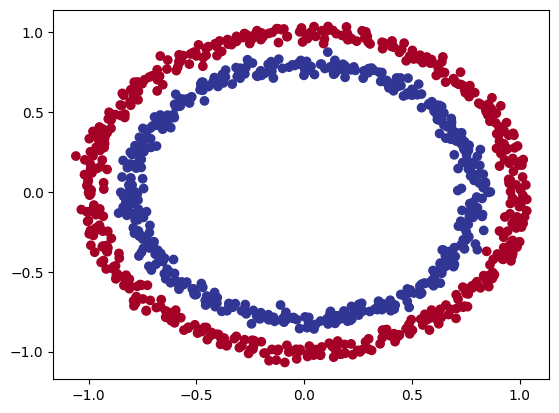

In [ ]:
# Visualizing
plt.scatter(x=X[:, 0],
             y=X[:, 1],
             c=y,
             cmap=plt.cm.RdYlBu);

#1.1 Checking Input and Output shapes and turn into tensor

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
#X = torch.from_numpy(X).type(torch.float) # by default torch.float is float32
#y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #0,2-> 20% of the data will be testing dataset
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
# Building a model

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Constructing a model that subclasses nn.module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Creating 2 nn.Linear layers capable of handling the shapes of the data
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # takes in 2 input featues and produces an output layer with 5 features if there are more layers then this output layer will serve as an input layer to the next layer and is called as the hidden layer
    self.layer_2 = nn.Linear(in_features=5, out_features=1)# one matches the shape of our labels(y which is one)

  # Define a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))  # x ->layer_1 ->layer_2 -> output

model_0 = CircleModelV0().to(device)
#model_0.state_dict()



In [ ]:
# Making predictions
with torch.inference_mode():
  untrained_preds= model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 labels: {y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


* The loss function in the case of Regression was Mean Absolute Error(MAE) *or* Mean Squared Error(MSE)

* But for classification problems we use Binary Cross Entropy *or* categorical cross entropy.

In [ ]:
# Setting up loss fn
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss() = built in sigmoid fn

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculating the accuracy

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc


### Training

In [ ]:
y_logits = model_0(X_test.to(device))[:5]
y_pred_probs = torch.sigmoid(y_logits)

# Training and testing loop

In [ ]:
torch.manual_seed(42)

# no of iterations
epochs = 100

# put data into target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#training and test loop
for epoch in range(epochs):
  ## train
  model_0.train()

  #1. Forward pass(model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits->pred probs -> pred_labels


  #2 Calculate loss
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3. Optimizer stzero gradep
  optimizer.zero_grad()

  #4. loss backpropogation
  loss.backward()

  #5. optimizer step
  optimizer.step()


  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Printing out results
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}")




Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547


 The block below is Not written by me

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



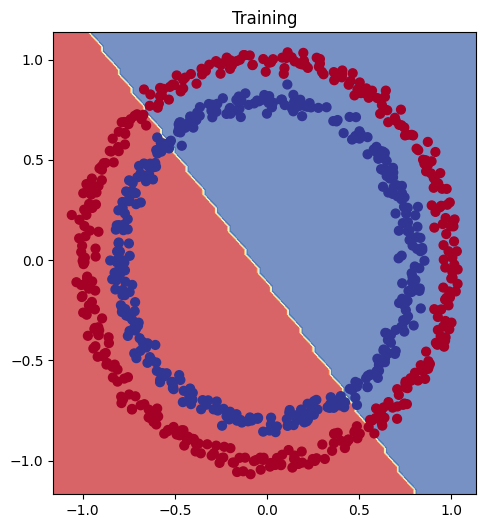

In [ ]:
# plot decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundary(model_0, X_train, y_train)

The model is underfitting the data

trying to improve the model performance by :


*   Adding more layers
*   Training with more epochs
*   Using diff. activation functions
*   Change the learning rate

these can be adjusted by me and are reffered to as Hyperparameters.





In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10) #extra layer
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)

In [ ]:
# loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

Training for longer # HIGHER NO.of EPOCHS

In [ ]:
epochs = 1000

# put data onto the target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## training

  # Forward pass
  y_logits = model_1(X_train).squeeze() # model_1(X_train)-> y_logits(in built sigmoid fn)->y_preds
  y_preds = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss= loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  # loss backward
  loss.backward()

  optimizer.step()

  ### testing
  model_1.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # test los
    test_loss = loss_fn(test_logits, y_test)

    #output
    if epoch%100 == 0 :
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.69396 | test loss: 0.69261
Epoch: 100 | Loss: 0.69305 | test loss: 0.69379
Epoch: 200 | Loss: 0.69299 | test loss: 0.69437
Epoch: 300 | Loss: 0.69298 | test loss: 0.69458
Epoch: 400 | Loss: 0.69298 | test loss: 0.69465
Epoch: 500 | Loss: 0.69298 | test loss: 0.69467
Epoch: 600 | Loss: 0.69298 | test loss: 0.69468
Epoch: 700 | Loss: 0.69298 | test loss: 0.69468
Epoch: 800 | Loss: 0.69298 | test loss: 0.69468
Epoch: 900 | Loss: 0.69298 | test loss: 0.69468


checking if the model fits the straight line

In [ ]:
weight = 0.7
bias = 0.3
start=0
end=1
step=0.01

#Creating data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression*weight+bias

# Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# train test splits , somehow does not work well on this data

#X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression,
                                                                                                #y_regression,
                                                                                                #test_size = 0.2,
                                                                                                #random_state=42)

#print (len(X_train_regression),
       #len(y_train_regression),
       #len(X_test_regression),
       #len(y_test_regression))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


In [ ]:
# Function for plotting predictions

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predicti
                     ons=None):
  """
  Plots training data, test data and compares predictions."""

  plt.figure(figsize=(8,8))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")

  #plot testing data in green
  plt.scatter(test_data,test_labels, c="g", s=4, label="testing data")

  #Check for predictions
  if predictions is not None:
    plt.scatter(test_data,predictions, c="r", s=4, label="Predictions")

  #Legend
  plt.legend(prop={"size":10});

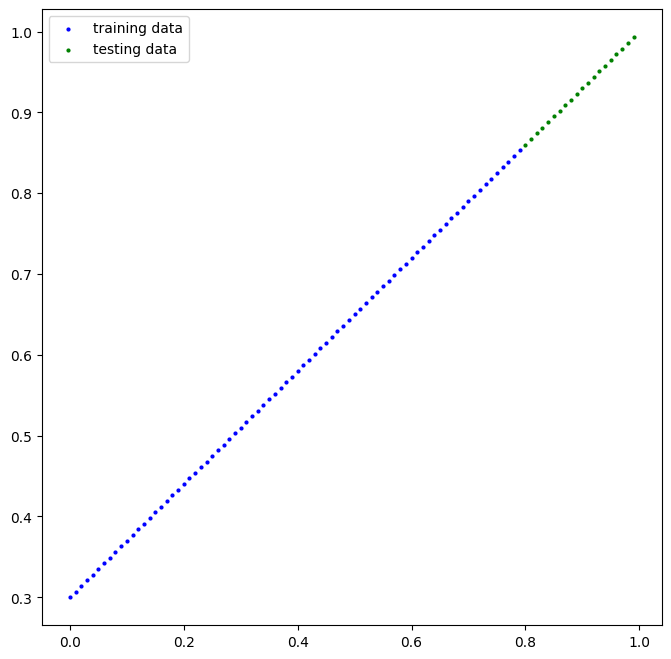

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression
);

In [ ]:
#nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
# training the model
torch.manual_seed(42)

# Set the no. of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  #1. Forward pass
  y_preds = model_2(X_train_regression)
  #2. Calculate the loss
  loss = loss_fn(y_preds, y_train_regression)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5.oPtimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_pred = model_2(X_test_regression)
    #2. Calculate loss
    test_loss = loss_fn(test_pred, y_test_regression)


  # printing the op
  if epoch % 100 ==0:
    print(f"Epoch: {epoch}| loss:{loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0| loss:0.57896, Test loss: 0.47265
Epoch: 100| loss:0.05652, Test loss: 0.17491
Epoch: 200| loss:0.05272, Test loss: 0.15038
Epoch: 300| loss:0.05733, Test loss: 0.14733
Epoch: 400| loss:0.05780, Test loss: 0.14758
Epoch: 500| loss:0.04943, Test loss: 0.12419
Epoch: 600| loss:0.05284, Test loss: 0.14350
Epoch: 700| loss:0.07244, Test loss: 0.12574
Epoch: 800| loss:0.04493, Test loss: 0.11135
Epoch: 900| loss:0.05377, Test loss: 0.13252


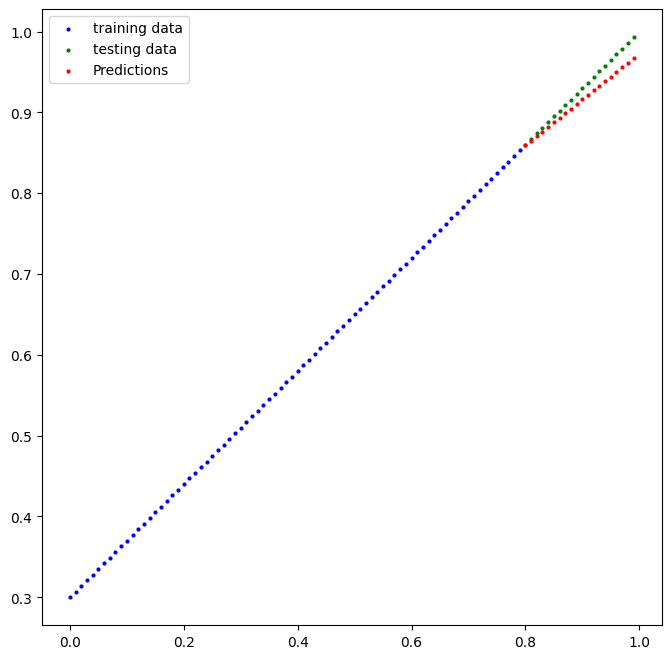

In [ ]:
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

In [ ]:
### Make and plot data

n_samples = 1000
X1,y1 = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
#plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
# Convert data to tensors and then into train-test split

import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors

#X1 = torch.from_numpy(X).type(torch.float)
#y1 = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(array([[ 0.65794626, -0.46508097],
        [ 0.63194897, -0.7346633 ],
        [-1.00861631, -0.12403051],
        [-0.96657519, -0.22562157],
        [-0.16659009,  0.79944645]]),
 array([1, 0, 0, 0, 1]))

In [ ]:
# building a non linear model
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()  # nonlinear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# setup loss and optimizer

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device) # Make sure training data is on the same device as the model
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

    # 4. Loss backward
  loss.backward()

    # 5. Optimizer step
  optimizer.step()

    ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



AttributeError: 'numpy.ndarray' object has no attribute 'to'